<!--
tags: [tutorial]
description: Code Executors
-->

# Code Executors

In the [last chapter](./human-in-the-loop), 
we used two agents powered by a large language model (LLM) to play a game. 
It was a fun exercise, but LLM by itself can only
generate text -- it cannot interact with its environment or performing useful
computations. 

In this chapter, we introduce code executor, an AutoGen's agent component that 
takes input messages with code blocks, performs execution, and output messages
with the results. There are currently two of types of built-in code 
executors available in AutoGen: command line executor and Jupyter executor.
For each type, there is a local version and a remote (i.e., docker) version.

We first cover the executors by themselves, and then show how to use
them in agent-to-agent conversation to solve coding tasks.

**Note**: Different from many other agent frameworks, AutoGen's code executor
can power an entire role of an agent: it can take input messages, execute code,
and output messages -- just like LLM.

In [89]:
import os
import tempfile
import shutil
import datetime
import pprint
from IPython.display import Image
from autogen import ConversableAgent, UserProxyAgent, AssistantAgent

## Command Line Code Executor

The command line code executor runs code in a local or remote command line
environment. It is useful for running code blocks of different programming
languages (i.e., Python, R, etc.) in the same conversation, 
and code blocks that each is a complete script or source of executable.
Each code block is executed in a new subprocess, so the variables created
within one code block are not accessible in another code block.

### Local Command Line Code Executor

The local command line code executor runs code in the same environment as the
AutoGen agent. It is useful mostly for development and testing, but not ideal
for production use case, as LLM can generate arbitrary code.

The figure below illustrates how does the local command line code executor work.

```{=mdx}
![Local Command Line Code Executor](./assets/local-command-line-code-executor.png)
```

Once receiving a message with a code block, the local command line code executor
first writes the code block to a code file, then start a new subprocess to
execute the code file. The executor reads the console output of the 
code execution and sends it back as a reply message.

Here is an example of using the local command line code executor to run a Python
code block that prints a random number.
First we create an agent with the local command line code executor
that uses a temporary directory to store the code files.

In [38]:
# Create a temporary directory to store the code files.
temp_dir = tempfile.mkdtemp()

# Create an agent with code executor configuration for a local command line
# code executor.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={
        "executor": "commandline-local",  # Use the local command line executor.
        "commandline-local": {
            "timeout": 10,  # Timeout for each code execution in seconds.
            "work_dir": temp_dir,  # Use the temporary directory to store the code files.
        },
    },
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

Now we have the agent generate a reply given a message with a Python code block.

In [60]:
message_with_code_block = (
    "This is a message with code block. "
    "The code block is below: \n"
    "```python\n"
    "import random\n"
    "print('A Random Number: ', random.randint(1, 100))\n"
    "```\n"
    "This is the end of the message.\n"
)

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: 
A Random Number:  39



During the generation of response, a human input is requested to give an opportunity
to intercept the code execution.
In this case, we choose to continue the execution, 
and the agent's reply contains the output of the code execution.

We can take a look at the code file that was created in the temporary directory.

In [36]:
code_files = os.listdir(temp_dir)
print(code_files)
print(open(os.path.join(temp_dir, code_files[0])).read())

['4595c0528b2d49d396732d9be1470a35.py']
import random
print('A Random Number: ', random.randint(1, 100))


The code file matches the code block that we sent to the agent.

Finally, let's clean up the temporary directory.

In [37]:
shutil.rmtree(temp_dir)

### Docker Command Line Code Executor

Code executor is a powerful tool, but it can also be dangerous because it can 
affect the environment it runs it. 
For example, it can delete files, send data to a remote server, 
or even mine cryptocurrency. 
To mitigate these risks, we can execute code in a docker container. 
This way, the generated code can only access resources that are explicitly 
given to it.

The figure below illustrates how does the docker command line code executor work.

```{=mdx}
![Docker Command Line Code Executor](./assets/docker-command-line-executor.png)
```

Similar to the local command line code executor, the docker command line code
executor extracts code blocks from input messages, writes them to code files.
For each code file, it starts a docker container to execute the code file,
and reads the console output of the code execution.

[Discuss containerization once that piece is ready.]

## Jupyter Code Executors

The command line code executor is useful for executing scripts, however, it does
not keeps the variables created during execution in memory.
If the code execution encounters an error, the script would be modified and
executed again, and all previous progress would be lost.
In some use cases, such as data analysis and machine learning, parts of the code
may be expensive or slow to run, e.g., loading data and running training, 
so we really want to keep the variables in memory to avoid re-running the 
entire code.

Jupyter code executors are designed for these use cases.
It runs code in a stateful, interactive kernel, 
such as a Python kernel or a Scala kernel, and keeps the variables in memory 
so the variables created in one code block are accessible in a subsequent 
code block.
If one code block encounters an error, the previous variables are still in memory,
and only the buggy code block needs to be modified and re-executed.

There are two types of Jupyter code executors: local Jupyter code executor and
remote Jupyter code executor.

### Local Jupyter Code Executor

The local Jupyter code executor starts a Jupyter server in the same environment
as the AutoGen agent as a subprocess.
The figure below illustrates how does the local Jupyter code executor work.

```{=mdx}
![Local Jupyter Code Executor](./assets/local-jupyter-code-executor.png)
```

Upon receiving a message with a code block, the local Jupyter code executor
sends the code block to the Jupyter server to have it executed in a kernel.
Then, it receives the output of the code execution.
Under the hood, the executor communicates with the Jupyter server 
through websocket.

Let us see an example of using the local Jupyter code executor to run a Python
code block that generates some random numbers, and then use the variable in 
a subsequent code block.

First we need to install additional dependencies to use the Jupyter executor.

In [33]:
! pip install -qqq 'pyautogen[local-jupyter-exec]'

Due to a bug in jupyter kernel gateway on Windows, please use the following
installation command on Windows.

In [34]:
# ! pip install -qqq 'pyautogen[ipython]'

We create an agent with a local Jupyter code executor, and asks it to
generates a reply with a given code block in markdown.

In [54]:
temp_dir = tempfile.mkdtemp()

# Create an agent with code executor configuration for a local Jupyter
# code executor.
jupyter_agent = ConversableAgent(
    name="Jupyter_Agent",
    llm_config=False,
    code_execution_config={
        "executor": "jupyter-local",  # Use the local Jupyter executor.
        # On Windows use "ipython-embedded" instead of "jupyter-local"
        # due to a known issue with Jupyter Kernel Gateway on Windows.
        "jupyter-local": {
            "timeout": 60,  # Timeout for each code execution in seconds.
            "kernel_name": "python3",  # Use the Python 3 kernel, which is the default.
            "output_dir": temp_dir,  # Use the temporary directory to store output images.
        },
    },
    human_input_mode="ALWAYS",
)

Ask the agent to generate a reply for a message that contains two Python
code blocks.

In [55]:
message_with_code_blocks_1 = (
    "First import the required libraries: \n"
    "```python\n"
    "import numpy as np\n"
    "import matplotlib.pyplot as plt\n"
    "```\n"
    "\n"
    "Now let's generate random numbers.\n"
    "```python\n"
    "np.random.seed(0)\n"
    "x = np.random.rand(100)\n"
    "y = np.random.rand(100)\n"
    "````n"
)

# Generate a reply for the first code message.
reply = jupyter_agent.generate_reply(
    messages=[
        {
            "role": "user",
            "content": message_with_code_blocks_1,
        }
    ]
)
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
exitcode: 0 (execution succeeded)
Code output: 



Ask the agent to generate a reply for a message that contains a Python code
block that generates a plot using the variables from the code block
in the previous message.

In [57]:
message_with_code_blocks_2 = (
    "Now let's plot the random numbers. \n"
    "```python\n"
    "plt.scatter(x, y)\n"
    "plt.xlabel('X')\n"
    "plt.ylabel('Y')\n"
    "plt.title('Random Numbers')\n"
    "plt.show()\n"
    "```\n"
)

# Generate a reply for the second code message.
reply = jupyter_agent.generate_reply(
    messages=[
        {
            "role": "user",
            "content": message_with_code_blocks_2,
        }
    ]
)
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
exitcode: 0 (execution succeeded)
Code output: <Figure size 640x480 with 1 Axes>
Image data saved to /var/folders/1j/84srcy411pv53xkqm57pvgnr0000gn/T/tmptwn7jp72/77cfc432c7a946d48c47c7932e467c03.png


From the output, we can see that the code blocks from all the messages are 
executed in the same kernel, and the variables `x` and `y` created in the
first message's code block are accessible in the second message's code block.

Let's take a look at the output of the plot in the output directory.

['77cfc432c7a946d48c47c7932e467c03.png']


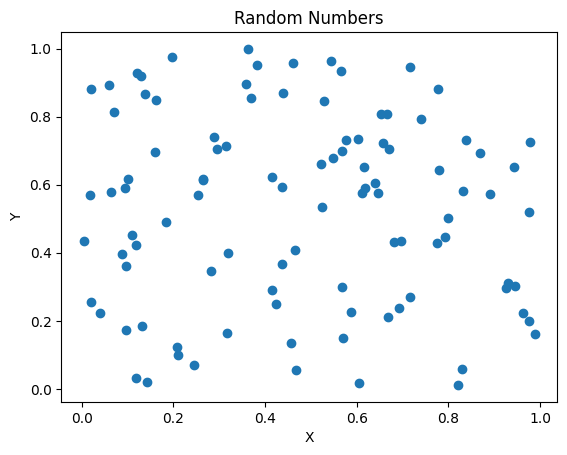

In [58]:
output_files = os.listdir(temp_dir)
print(output_files)
Image(os.path.join(temp_dir, output_files[0]))

Don't forget to clean up the temporary directory.

In [59]:
shutil.rmtree(temp_dir)

You can restart the Jupyter server by calling the `restart` method on the
agent's `code_executor` attribute.

In [79]:
jupyter_agent.code_executor.restart()

### Remote Jupyter Code Executor

[Discuss the remote Jupyter executor once that piece is ready.]

## Use Code Execution in Conversation

Writing and executing code is necessary for many tasks such as 
data analysis, machine learning, and mathematical modeling.
In AutoGen, coding can be a conversation between a code writer agent and a 
code executor agent, mirroring the interaction between a programmer and a
code interpreter.

```{=mdx}
![Code Writer and Code Executor](./assets/code-execution-in-conversation.png)
```

The code writer agent can be powered by an LLM such as GPT-4 with code-writing
capability.
And the code executor agent is powered by a code executor.

The following is an agent with a code writer role specified 
using `system_message`.

In [63]:
# The code writer agent's system message is to instruct the LLM on how to
# use the Jupyter code executor with IPython kernel.
code_writer_system_message = (
    "You have been given coding capability to solve tasks using Python code in a stateful IPython kernel.\n"
    "You are responsible for writing the code, and the user is responsible for executing the code.\n"
    "\n"
    "When you write Python code, put the code in a markdown code block with the language set to Python.\n"
    "For example:\n"
    "```python\n"
    "x = 3\n"
    "```\n"
    "You can use the variable `x` in subsequent code blocks.\n"
    "```python\n"
    "print(x)\n"
    "```\n"
    "\n"
    "Write code incrementally and leverage the statefulness of the kernel to avoid repeating code.\n"
    "Import libraries in a separate code block.\n"
    "Define a function or a class in a separate code block.\n"
    "Run code that produces output in a separate code block.\n"
    "Run code that involves expensive operations like download, upload, and call external APIs in a separate code block.\n"
    "\n"
    "When your code produces an output, the output will be returned to you.\n"
    "Because you have limited conversation memory, if your code creates an image,\n"
    "the output will be a path to the image instead of the image itself.\n"
)

code_writer_agent = ConversableAgent(
    "code_writer",
    system_message=code_writer_system_message,
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]},
    code_execution_config=False,  # Turn off code execution for this agent.
)

We need to install additional dependencies to use the Jupyter executor.

In [64]:
! pip install -qqq 'pyautogen[local-jupyter-exec]'
# On Windows, use the following due to a known issue with Jupyter Kernel Gateway.
# ! pip install -qqq 'pyautogen[ipython]'

The following is an agent with a code executor role specified using 
its `code_execution_config`. It uses a local Jupyter code executor
with `python3` kernel.

In [81]:
# Create a temporary directory to store the output images.
temp_dir = tempfile.mkdtemp()

# Create an agent with code executor configuration for a local Jupyter
# code executor.
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={
        "executor": "jupyter-local",  # Use the local Jupyter executor.
        # On Windows use "ipython-embedded" instead of "jupyter-local"
        # due to a known issue with Jupyter Kernel Gateway on Windows.
        "jupyter-local": {
            "timeout": 60,  # Timeout for each code execution in seconds.
            "kernel_name": "python3",  # Use the Python 3 kernel, which is the default.
            "output_dir": temp_dir,  # Use the temporary directory to store output images.
        },
    },
    human_input_mode="ALWAYS",
)

Here is an example of solving a math problem through a conversation
between the code writer and the code executor:

In [83]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

Sure, I'll use a simple iterative method to calculate the 14th Fibonacci number. 

```python
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

fibonacci(14)
```

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_executor_agent (to code_writer):

exitcode: 0 (execution succeeded)
Code output: 377

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

The 14th Fibonacci number is 377.

--------------------------------------------------------------------------------


During the previous chat session, human input was requested each time
the code executor agent responded to ensure that the code was safe to execute.

Now we can try a more complex example that involves querying the web.
Let's say we want to get the the stock prices year-to-date for
Tesla and Meta (formerly Facebook). We can also use the two agents
with several iterations of conversation.


In [84]:
today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent, message=f"Today is {today}. Write Python code to plot TSLA's and META's stock prices YTD."
)

code_executor_agent (to code_writer):

Today is 2024-02-26. Write Python code to plot TSLA's and META's stock prices YTD.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

First, let's install the `yfinance` library that will allow us to fetch the stock price data. We will also need `matplotlib` for plotting and `pandas` for data manipulation.

Your code block should look like this:

```python
!pip install yfinance matplotlib pandas
```

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_executor_agent (to code_writer):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

Great! Now that the required libraries are installed, let's import them:


Let's take a look at the chart that was generated.

['cf146a5cff554a678621a786ecd70ff0.png']


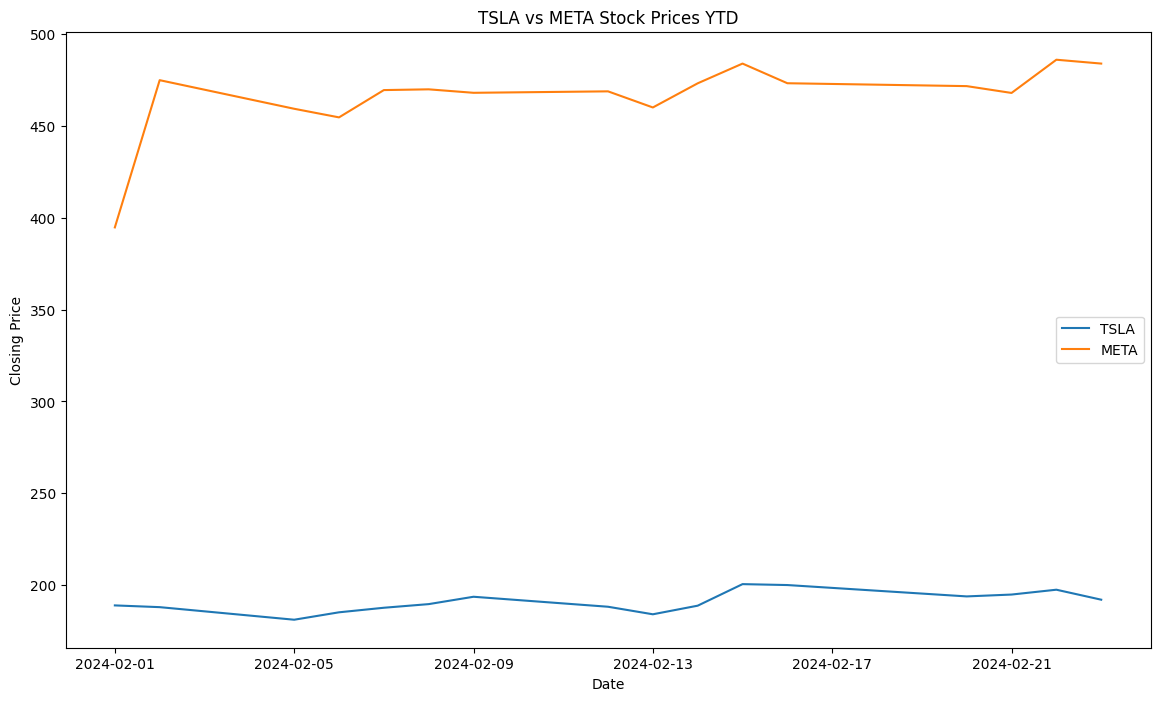

In [85]:
output_files = os.listdir(temp_dir)
print(output_files)
Image(os.path.join(temp_dir, output_files[0]))

Clean up the temporary directory and restart the Jupyter server to free up
the kernel resources.

In [86]:
shutil.rmtree(temp_dir)
code_executor_agent.code_executor.restart()

## Note on Legacy Code Executor

In existing AutoGen code, you may see
`code_execution_config={}` 
or 
`code_execution_config={"use_docker": False, "work_dir": "path/to/work_dir"}` 
specified
in agent's constructor.
This is the legacy way of specifying the code executor.
The default value of `code_execution_config` is `{}` which means to use
a similar version of docker command line code executor,
while `{"use_docker": False}` means to use a similar version of local
command line code executor.

We recommend using the new way of specifying the code executor,
which gives more flexibility and extensibility: you can choose different
types of code executors and even supply your own code executor by
passing a custom implementation of `autogen.coding.CodeExecutor`: `code_execution_config={"executor": CustomExecutor()}`.

## Note on User Proxy Agent and Assistant Agent

### User Proxy Agent

In the previous examples, the code executor agent is created directly using
`ConversableAgent` class. In existing AutoGen code, the code executor
agent is often created using `UserProxyAgent` class, which is a subclass of
`ConversableAgent` with `human_input_mode=ALWAYS` and `llm_config=False` --
it always requests human input for every message and does not use LLM.
It also comes with default `description` field for each of the
`human_input_mode` setting.
This class is a convenient short-cut for creating an agent that is
intended to be used as a code executor.

The default `code_execution_config` for `UserProxyAgent` is currently set 
to use the legacy
code executor with `{"use_docker": True}`.
The default `description` field is also currently tuned for the legacy code
executor which executes code in command line.

In [90]:
pprint.pprint(UserProxyAgent.DEFAULT_USER_PROXY_AGENT_DESCRIPTIONS)

{'ALWAYS': 'An attentive HUMAN user who can answer questions about the task, '
           'and can perform tasks such as running Python code or inputting '
           'command line commands at a Linux terminal and reporting back the '
           'execution results.',
 'NEVER': 'A computer terminal that performs no other action than running '
          'Python scripts (provided to it quoted in ```python code blocks), or '
          'sh shell scripts (provided to it quoted in ```sh code blocks).',
 'TERMINATE': 'A user that can run Python code or input command line commands '
              'at a Linux terminal and report back the execution results.'}



### Assistant Agent

In the previous examples, the code writer agent is created directly using
`ConversableAgent` class. In existing AutoGen code, the code writer
agent is often created using `AssistantAgent` class, which is a subclass of
`ConversableAgent` with `human_input_mode=NEVER` and `code_execution_config=False` -- it never requests human input and does not use code executor.
It also comes with default `system_message` and `description` fields.
This class is a convenient short-cut for creating an agent that is
intended to be used as a code writer and does not execute code.

**Important:** The default `system_message` of `AssistantAgent` is currently
tuned for the legacy code executor which executes code in command line.
If you are not using the command line code executor, 
you may need to modify the 
`system_message` make sure appropriate instruction is provided.

In [91]:
pprint.pprint(AssistantAgent.DEFAULT_SYSTEM_MESSAGE)

('You are a helpful AI assistant.\n'
 'Solve tasks using your coding and language skills.\n'
 'In the following cases, suggest python code (in a python coding block) or '
 'shell script (in a sh coding block) for the user to execute.\n'
 '    1. When you need to collect info, use the code to output the info you '
 'need, for example, browse or search the web, download/read a file, print the '
 'content of a webpage or a file, get the current date/time, check the '
 'operating system. After sufficient info is printed and the task is ready to '
 'be solved based on your language skill, you can solve the task by yourself.\n'
 '    2. When you need to perform some task with code, use the code to perform '
 'the task and output the result. Finish the task smartly.\n'
 'Solve the task step by step if you need to. If a plan is not provided, '
 'explain your plan first. Be clear which step uses code, and which step uses '
 'your language skill.\n'
 'When using code, you must indicate the scrip

In [92]:
pprint.pprint(AssistantAgent.DEFAULT_DESCRIPTION)

('A helpful and general-purpose AI assistant that has strong language skills, '
 'Python skills, and Linux command line skills.')


### Best Practice
As a best practice, if you are not using the command line code executors, 
we recommend using `ConversableAgent` directly and specify the
`system_message` and `description` explicitly instead
of `UserProxyAgent` and `AssistantAgent`
as they are tuned for the legacy code executor.

## Summary

In this chapter, we introduced code executors: command line executors and
Jupyter executors. 
We also showed how to use code executor in a conversation between
a code writer agent and a code executor agent.
In [the next chapter](./conversation-patterns), we will introduce conversation patterns, and show
how to use the result of a conversation.